In [1]:
#import all the libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
import time

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

import Densenet_from_scratch as Densenet121

In [2]:
#define image size

image_size = 224

#define the labels

labels = ['1_NORMAL', '2_BACTERIA','3_VIRUS']

#create a function to load the image and labels

def create_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)
            images.append([image_resized,class_num])
            
    return np.array(images)

#create the training and validation set

train = create_data('D:/Kaggle datasets/chest_xray_tf/train')
val = create_data('D:/Kaggle datasets/chest_xray_tf/val')

print(f'Shape of the training images = {train.shape}')
print(f'Shape of the validation images = {val.shape}')

Shape of the training images = (5706, 2)
Shape of the validation images = (150, 2)


In [3]:
#load train images and labels in X and y

X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y, axis=1)

#Load validation images and labels in X_val and y_val

X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val= np.array(X_val)
y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=1)

In [4]:
#split train images into train and test
#20% images will be used for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state = 32, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5135, 224, 224, 3)
(571, 224, 224, 3)
(5135, 1)
(571, 1)


Number of Normal images = 1379
Number of Bacteria images = 2457
Number of Virus images = 1299


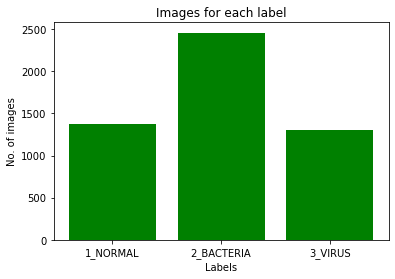

In [5]:
#check the number of images in each class in train set

a = 0
b = 0
c = 0

for label in y_train:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
    if label == 2:
        c += 1
        
print (f'Number of Normal images = {a}')
print (f'Number of Bacteria images = {b}')
print (f'Number of Virus images = {c}')

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [a,b,c]
plt.bar(xe,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")

plt.xticks(xe, labels)

plt.show()

In [6]:
# find the difference from the majority class

difference_normal = b-a
difference_virus = b-c

print(difference_normal)
print(difference_virus)

1078
1158


In [7]:
# artificial data augmentation of the minority classes

def rotate_images(image, scale =1.0, h=224, w = 224):
    
    center = (h/2,w/2)
    
    angle = random.randint(-25,25)
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (h,w))
    return rotated

def flip (image):
    
    flipped = np.fliplr(image)
    return flipped

def translation (image):
    
    x= random.randint(-50,50)
    y = random.randint(-50,50)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv.warpAffine(image,M,(cols,rows))
    
    return translate

def blur (image):
    
    x = random.randrange(1,5,2)
    blur = cv.GaussianBlur(image,(x,x),cv.BORDER_DEFAULT)
    return blur

# function to apply the above augmentations at random


def apply_aug (image):
    
    number = random.randint(1,4)
    
    if number == 1:
        image= rotate_images(image, scale =1.0, h=224, w = 224)
            
    if number == 2:
        image= flip(image)
                
    if number ==3:
        image= translation(image)
                
    if number ==4:
        image= blur(image)
    
    return image

In [8]:
# apply the augmentations to oversample the images

def oversample_images (difference_normal,difference_virus, X_train, y_train):
    
    normal_counter = 0
    virus_counter= 0
    new_normal = []
    new_virus = []
    label_normal = []
    label_virus = []
    
    for i,item in enumerate (X_train):
        
        if y_train[i] == 0 and normal_counter < difference_normal:
            
            image = apply_aug(item)
            
            normal_counter = normal_counter+1
            label = 0
            
            new_normal.append(image)
            label_normal.append(label)
            
            
        if y_train[i] == 2 and virus_counter < difference_virus:
            
            image = apply_aug(item)
            
            virus_counter = virus_counter+1
            label =2
            
            new_virus.append(image)
            label_virus.append(label)
            
    
    new_normal = np.array(new_normal)
    label_normal = np.array(label_normal)
    new_virus= np.array(new_virus)
    label_virus = np.array(label_virus)
    
    return new_normal, label_normal, new_virus, label_virus

In [9]:
# check the number of newly created images

n_images,n_labels,v_images,v_labels =oversample_images(difference_normal,difference_virus,X_train,y_train)

print(n_images.shape)
print(n_labels.shape)
print(v_images.shape)
print(v_labels.shape)

(1078, 224, 224, 3)
(1078,)
(1158, 224, 224, 3)
(1158,)


Display Random Images


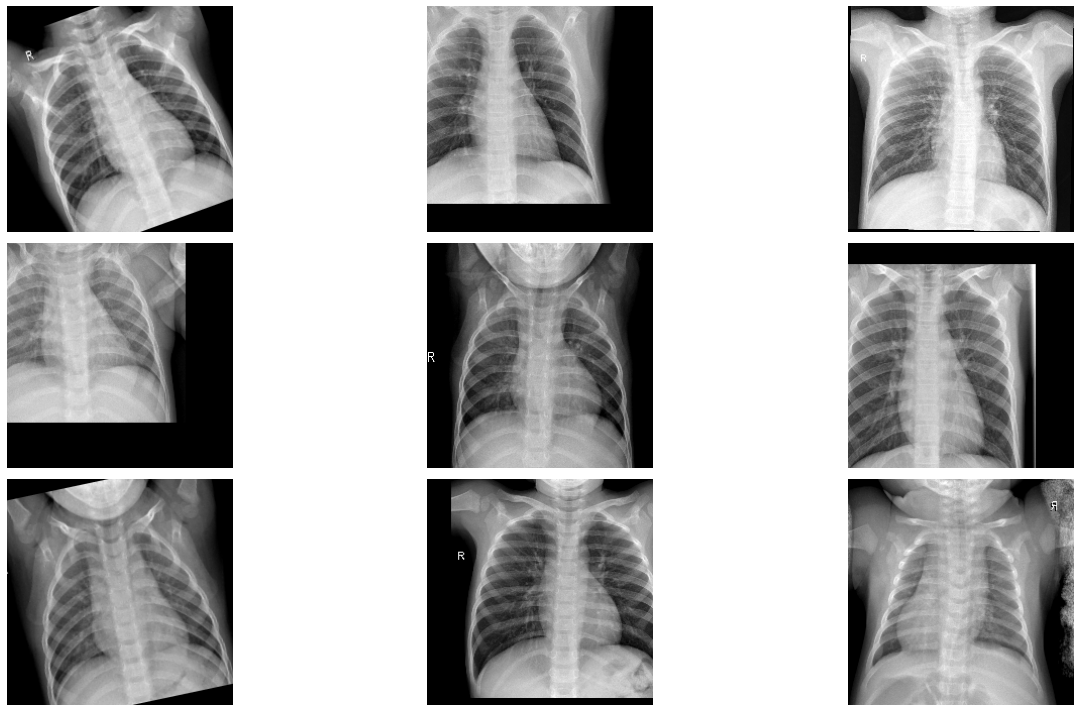

In [10]:
# Displays 9 generated bacterial images 
# Extract 9 random images
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,len(n_images)-1)
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(n_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display Random Images


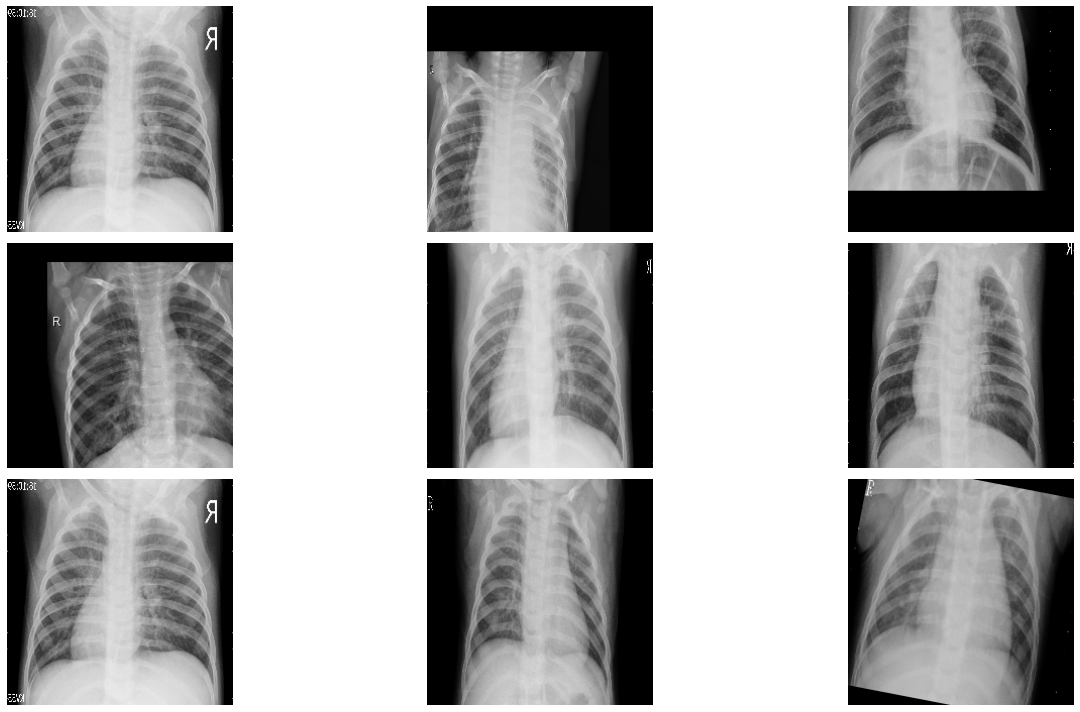

In [11]:
# Displays 9 generated viral images 
# Extract 9 random images
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,len(v_images)-1)
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(v_images[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [12]:
#merge the new images with the original images

new_labels = np.append(n_labels,v_labels)
y_new_labels = np.expand_dims(new_labels, axis=1)
x_new_images = np.append(n_images,v_images,axis=0)

X_train = np.append(X_train,x_new_images,axis=0)
y_train = np.append(y_train,y_new_labels)

print(X_train.shape)
print(y_train.shape)

(7371, 224, 224, 3)
(7371,)


Number of Normal images = 2457
Number of Bacteria images =  2457
Number of Virus images = 2457


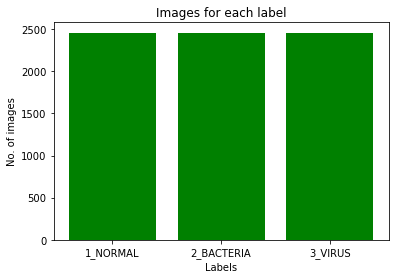

In [13]:
#training set after oversampling

bacteria_new=0
virus_new=0
normal_new =0

for i in y_train:
    
    if i==0:
        normal_new = normal_new+1
    elif i==1 :
        bacteria_new = bacteria_new+1
    else:
        virus_new=virus_new+1    
        
print ('Number of Normal images =',normal_new)
print ('Number of Bacteria images = ',bacteria_new)
print ('Number of Virus images =',virus_new)

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [normal_new, bacteria_new, virus_new]
plt.bar(xe,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")

plt.xticks(xe, labels)

plt.show()

In [14]:
def get_train_generator(X_train,y_train, batch_size = 32, shuffle = True, seed = 1):
      
    print("getting train generator...") 
    # normalize and augment images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        rotation_range = 15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest",
        cval=0.0,
        rescale = 0.2)
    
    generator = image_generator.flow(
            X_train,
            y=y_train,
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed
            )
    
    return generator

In [15]:
def get_test_val_generator(X_train,y_train,X_test,y_test,X_val,y_val,
                      batch_size=32, seed=1, sample_size=100):
    
    raw_train_generator = ImageDataGenerator().flow(
        X_train,y_train, 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
    # get test generator
    test_generator = image_generator.flow(
            X_test,
            y=y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    #get validation generator
    val_generator = image_generator.flow(
            X_val,
            y=y_val,
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return test_generator,val_generator

In [16]:
#create the train, test and validation generator

train_generator = get_train_generator(X_train,y_train)
test_generator,valid_generator = get_test_val_generator(X_train,y_train,X_test,y_test,X_val,y_val)

getting train generator...


Display Random Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

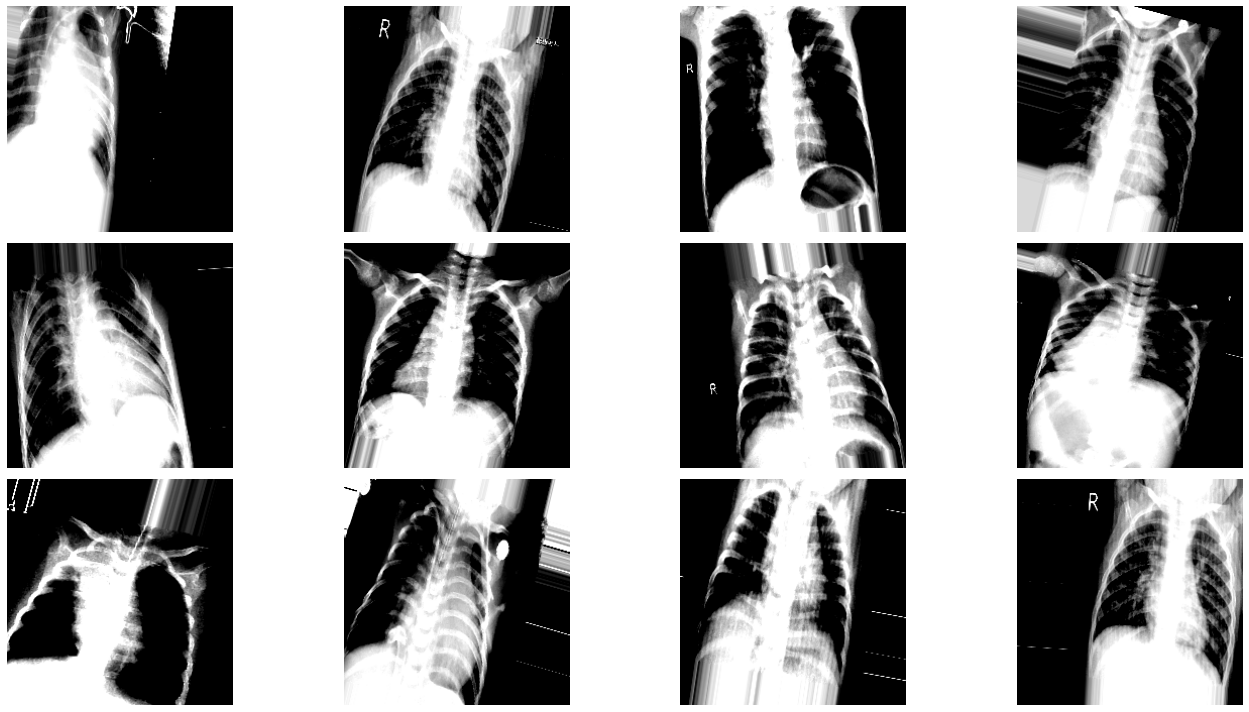

In [17]:
# Displays 9 generated train_generator images 

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(12):
    num = random.randint(1,30)
    plt.subplot(3,4, i + 1)
    
    x,y = train_generator.__getitem__(num)
    
    plt.imshow(x[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Display Random Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


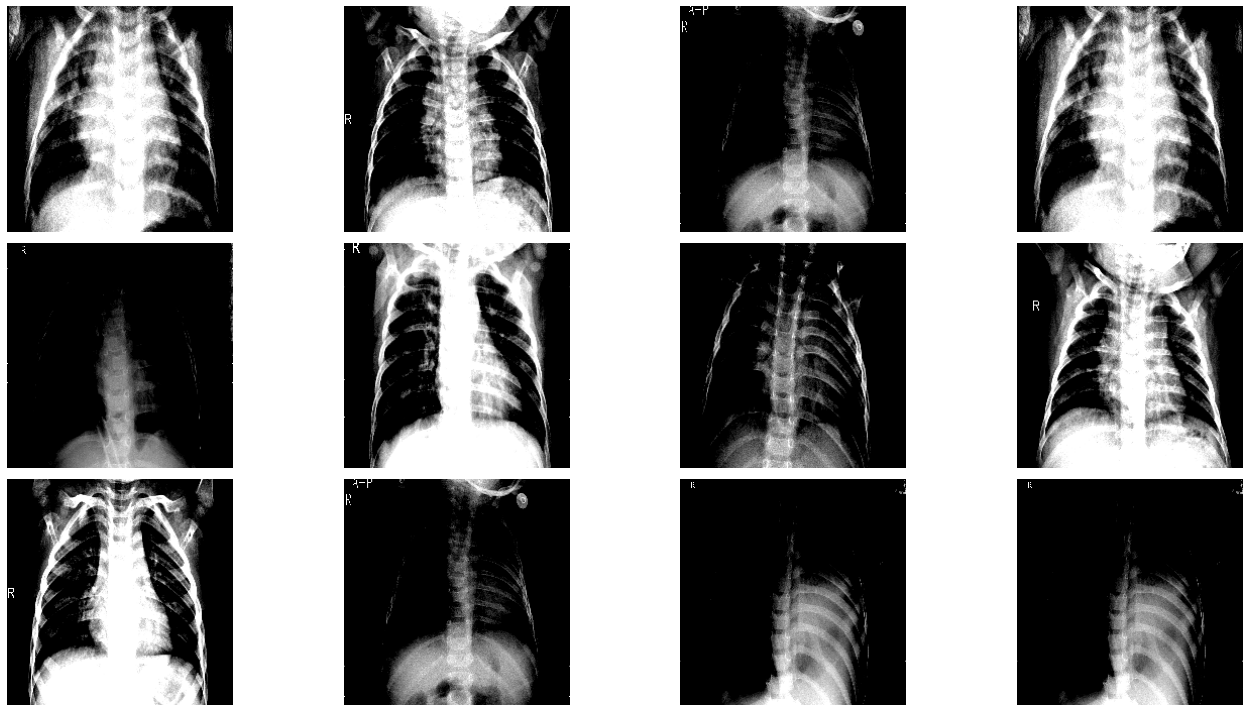

In [18]:
# Displays 9 generated test_generator images 

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(12):
    num = random.randint(1,17)
    plt.subplot(3,4, i + 1)
    
    x,y = test_generator.__getitem__(num)
    
    plt.imshow(x[num],cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [19]:
x_gen,y_gen = train_generator.next()
y_gen

array([0, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0,
       1, 2, 0, 1, 1, 2, 0, 2, 0, 0])

In [20]:
def scheduler(epoch):
    if epoch < 50:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

stopping = EarlyStopping(monitor='val_loss', patience=15)

In [21]:
input_shape = 224,224,3

model = Densenet121.densenet(input_shape=input_shape, n_classes=3, filters = 32)

In [22]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()                   

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [23]:
start_time = time.time()

In [24]:
callbacks = ModelCheckpoint('Trained_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 32

r = model.fit(train_generator, validation_data=(test_generator), 
                        steps_per_epoch = X_train.shape[0]//batch_size, epochs= 100, 
                        callbacks = [callbacks,lr_schedule,stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 230 steps, validate for 18 steps
Epoch 1/100
229/230 [============================>.] - ETA: 0s - loss: 0.7361 - accuracy: 0.6679
Epoch 00001: val_loss improved from inf to 1.28164, saving model to Trained_model.h5
230/230 [==============================] - 75s 326ms/step - loss: 0.7348 - accuracy: 0.6686 - val_loss: 1.2816 - val_accuracy: 0.3660
Epoch 2/100
229/230 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.7474
Epoch 00002: val_loss improved from 1.28164 to 0.96098, saving model to Trained_model.h5
230/230 [==============================] - 58s 253ms/step - loss: 0.5900 - accuracy: 0.7476 - val_loss: 0.9610 - val_accuracy: 0.5604
Epoch 3/100
229/230 [============================>.] - ETA: 0s - loss: 0.5526 - accuracy: 0.7721
Epoch 00003: val_loss did not improve from 0.96098
230/230 [==============================] - 57s 250ms/step - loss: 0.5523 - accuracy: 0.7720 - val_loss: 1.2125 - val_accura

229/230 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8731
Epoch 00028: val_loss did not improve from 0.45294
230/230 [==============================] - 57s 250ms/step - loss: 0.3040 - accuracy: 0.8731 - val_loss: 0.5532 - val_accuracy: 0.7811
Epoch 29/100
229/230 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8793
Epoch 00029: val_loss did not improve from 0.45294
230/230 [==============================] - 57s 249ms/step - loss: 0.3000 - accuracy: 0.8797 - val_loss: 0.5503 - val_accuracy: 0.8091
Epoch 30/100
229/230 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8745
Epoch 00030: val_loss did not improve from 0.45294
230/230 [==============================] - 57s 250ms/step - loss: 0.2935 - accuracy: 0.8746 - val_loss: 0.6552 - val_accuracy: 0.7898
Epoch 31/100
229/230 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8826
Epoch 00031: val_loss did not improve from 0.45294
230/230 [======

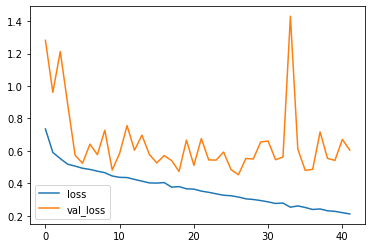

In [25]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

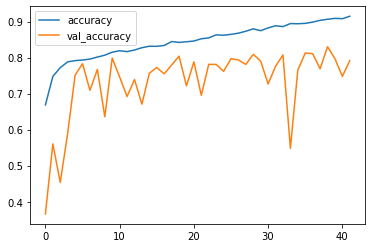

In [26]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [27]:
def perf_measure(y_holdout, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_holdout[i]==P[i]==1:
           TP += 1
        if y_holdout[i]==1 and y_holdout[i]!=P[i]:
           FP += 1
        if y_holdout[i]==P[i]==0:
           TN += 1
        if y_holdout[i]==0 and y_holdout[i]!=P[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [28]:
final_model = tf.keras.models.load_model('Trained_model.h5')

#### Val Set

In [29]:
P_test= final_model.predict(test_generator, steps=len(test_generator)).argmax(axis=1)
print(P_test)

[1 2 1 1 1 1 2 0 1 2 2 0 2 0 1 0 1 0 0 2 0 0 1 0 1 2 1 0 1 2 1 0 0 2 2 2 0
 1 1 1 1 1 0 0 2 1 2 1 0 2 0 0 2 0 0 2 1 0 1 1 1 0 1 0 0 2 1 0 2 2 0 1 2 2
 1 2 1 0 0 2 1 2 1 0 1 2 1 1 1 2 2 2 1 1 1 2 0 0 1 1 1 1 1 0 1 2 1 2 1 1 1
 1 1 0 0 2 1 1 1 0 1 0 1 1 0 1 2 0 1 2 1 2 2 2 0 2 1 2 0 1 0 2 0 2 1 1 1 1
 2 2 1 2 2 2 1 2 0 1 2 0 1 0 1 2 1 1 2 0 0 0 0 0 1 0 0 2 1 1 2 1 0 1 1 0 1
 1 1 2 2 1 1 0 1 2 1 1 0 0 0 1 0 1 0 0 0 0 2 1 2 1 0 0 0 1 2 2 2 0 2 2 2 0
 2 0 2 2 1 2 1 0 2 2 1 1 2 2 2 1 0 0 0 2 1 0 1 0 1 1 2 1 1 2 0 2 0 0 2 2 1
 2 0 1 2 1 2 2 0 1 2 1 2 1 0 2 2 0 1 2 1 1 0 1 0 1 2 2 2 2 0 1 1 0 0 0 1 0
 2 0 0 1 2 0 0 2 1 0 1 1 2 1 1 0 0 0 1 1 1 1 0 1 2 0 2 1 1 1 0 1 2 1 2 2 1
 1 2 2 0 1 1 2 2 1 2 2 1 1 1 2 2 1 0 0 2 2 2 0 1 1 1 1 1 2 1 1 1 2 1 0 0 1
 0 1 2 1 1 1 0 0 0 1 2 1 1 0 0 1 1 2 0 2 1 2 0 1 0 1 1 2 1 0 0 1 0 1 0 1 1
 0 1 1 2 1 1 1 0 0 1 0 2 1 1 2 2 2 0 2 1 1 1 1 2 0 2 2 2 2 1 0 1 0 1 2 1 2
 1 1 2 1 1 0 2 1 1 0 2 2 1 1 1 1 1 1 0 1 1 1 1 2 2 1 1 0 2 1 0 1 1 1 0 2 1
 2 0 1 2 2 2 1 1 2 2 1 0 

([<matplotlib.axis.YTick at 0x2a377926a48>,
 [Text(0, 0, '1_Normal'), Text(0, 0, '2_Bacteria'), Text(0, 0, '3_Virus')])

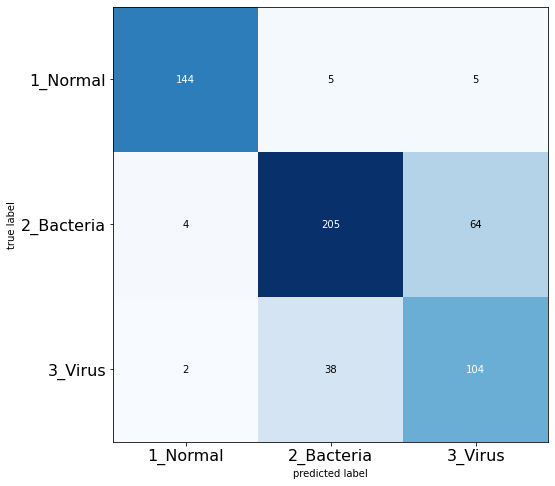

In [30]:
matrix1 = confusion_matrix (y_test, P_test)
plot_confusion_matrix(matrix1, figsize=(8,8))
plt.xticks(range(3), ['1_Normal','2_Bacteria','3_Virus'], fontsize=16)
plt.yticks(range(3), ['1_Normal','2_Bacteria', '3_Virus'], fontsize=16)

In [31]:
tp, fp, tn ,fn = perf_measure(y_test,P_test)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.95
Precision of the model is 0.75
F-Score is 0.84


#### Test Set

In [32]:
P_val= final_model.predict(valid_generator, steps=len(valid_generator)).argmax(axis=1)
print(P_val)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 2 1 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 2 1 2 1 2 1
 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 1 1 2 2 1 2 2 1 2 2 2
 2 1]


([<matplotlib.axis.YTick at 0x2a377982c08>,
 [Text(0, 0, '1_Normal'), Text(0, 0, '2_Bacteria'), Text(0, 0, '3_Virus')])

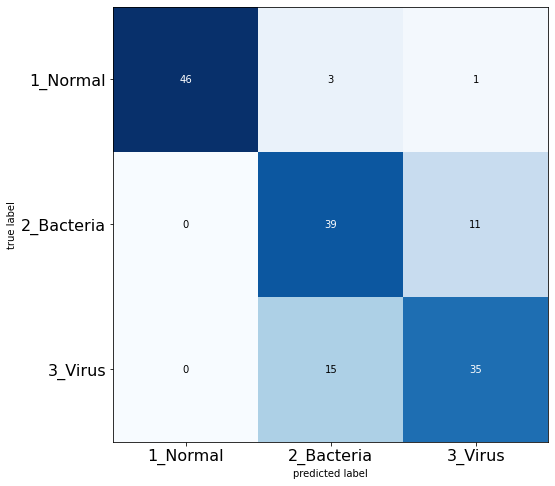

In [33]:
matrix = confusion_matrix (y_val, P_val)
plot_confusion_matrix(matrix, figsize=(8,8))
plt.xticks(range(3), ['1_Normal','2_Bacteria','3_Virus'], fontsize=16)
plt.yticks(range(3), ['1_Normal','2_Bacteria', '3_Virus'], fontsize=16)

In [34]:
tp, fp, tn ,fn = perf_measure(y_val,P_val)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.91
Precision of the model is 0.78
F-Score is 0.84


In [35]:
end_time= time.time()

print("--- %s seconds ---" % (end_time - start_time))

--- 2456.468912601471 seconds ---
